# 应用 4：多智能体协作

## 概览

多智能体系统由多个专业化智能体协同工作，用于解决复杂问题。

**本 notebook 演示真实的多智能体协作，基于 LLM 的推理驱动。**

### 为什么需要多智能体系统？

1. **分工协作**：每个智能体专注特定任务
2. **涌现智能**：组合后能解决单个智能体无法完成的问题
3. **质量控制**：智能体之间相互审阅与质检
4. **可扩展性**：按需添加新的专家智能体

## 常见的多智能体模式

1. **监督者模式**：由一个智能体统一协调
2. **辩论模式**：多个智能体讨论并达成共识
3. **流水线模式**：由专家按序处理
4. **群体模式**：自治智能体围绕共同目标协作


## 运行前：准备 Ollama 后端

如果你选择 Ollama 作为后端，请先完成准备步骤：
- 参见 [PREPARE_OLLAMA.ipynb](./PREPARE_OLLAMA.ipynb)

完成后再继续本 notebook。


## 环境准备与依赖


In [1]:
import sys
import os
sys.path.insert(0, os.path.dirname(os.getcwd()))

from typing import Dict, List, Any, Optional, Callable
from dataclasses import dataclass, field
from enum import Enum
from abc import ABC, abstractmethod
import time
import json
import re

# Import our LLM backend
from utils.llm_backend import get_llm_backend, BaseLLMBackend

print("Multi-Agent System dependencies loaded!")

Multi-Agent System dependencies loaded!


## Part 1：消息协议与基础 Agent

首先定义智能体之间的通信协议。


In [2]:
class MessageType(Enum):
    """Types of messages agents can send."""
    TASK = "task"           # Assignment of work
    RESULT = "result"       # Completed work
    QUESTION = "question"   # Request for clarification
    FEEDBACK = "feedback"   # Review/critique of work
    STATUS = "status"       # Progress update
    DELEGATE = "delegate"   # Delegation to sub-agent

@dataclass
class Message:
    """Structured message passed between agents."""
    sender: str
    receiver: str
    msg_type: MessageType
    content: Any
    context: Dict[str, Any] = field(default_factory=dict)
    timestamp: float = field(default_factory=time.time)
    message_id: str = field(default_factory=lambda: f"msg_{int(time.time()*1000)}")
    
    def __str__(self):
        preview = str(self.content)[:80] + "..." if len(str(self.content)) > 80 else str(self.content)
        return f"[{self.sender} -> {self.receiver}] ({self.msg_type.value}): {preview}"


class BaseAgent(ABC):
    """
    Base class for all LLM-powered agents.
    
    Each agent has:
    - A name and role description
    - An LLM backend for reasoning
    - Message inbox/outbox for communication
    - Internal state for tracking work
    """
    
    def __init__(
        self, 
        name: str, 
        role: str,
        llm: BaseLLMBackend,
        system_prompt: str = None
    ):
        self.name = name
        self.role = role
        self.llm = llm
        self.system_prompt = system_prompt or f"You are {name}, a {role}."
        
        # Communication
        self.inbox: List[Message] = []
        self.outbox: List[Message] = []
        self.message_history: List[Message] = []
        
        # State
        self.state: Dict[str, Any] = {}
        self.conversation_history: List[Dict[str, str]] = []
    
    def receive(self, message: Message):
        """Receive a message into inbox."""
        self.inbox.append(message)
        self.message_history.append(message)
    
    def send(self, receiver: str, msg_type: MessageType, content: Any, context: Dict = None) -> Message:
        """Create and queue a message to send."""
        msg = Message(
            sender=self.name,
            receiver=receiver,
            msg_type=msg_type,
            content=content,
            context=context or {}
        )
        self.outbox.append(msg)
        self.message_history.append(msg)
        return msg
    
    def think(self, prompt: str, include_history: bool = True) -> str:
        """
        Use LLM to reason about a prompt.
        
        Args:
            prompt: The prompt to reason about
            include_history: Whether to include conversation history
        
        Returns:
            LLM response
        """
        messages = []
        
        # Add system prompt
        messages.append({"role": "system", "content": self.system_prompt})
        
        # Add conversation history if requested
        if include_history:
            messages.extend(self.conversation_history[-10:])  # Last 10 exchanges
        
        # Add current prompt
        messages.append({"role": "user", "content": prompt})
        
        # Get LLM response
        response = self.llm.chat(messages)
        
        # Update conversation history
        self.conversation_history.append({"role": "user", "content": prompt})
        self.conversation_history.append({"role": "assistant", "content": response})
        
        return response
    
    def process(self) -> List[Message]:
        """
        Process all messages in inbox.
        Returns list of response messages.
        """
        responses = []
        for message in self.inbox:
            result = self._handle_message(message)
            if result:
                responses.extend(result if isinstance(result, list) else [result])
        self.inbox.clear()
        return responses
    
    @abstractmethod
    def _handle_message(self, message: Message) -> Optional[List[Message]]:
        """Handle a single message. Override in subclasses."""
        pass
    
    def __repr__(self):
        return f"{self.name} ({self.role})"




## Part 2：专业化 LLM Agent

为软件开发工作流创建专业化智能体：
- **PlannerAgent**：拆解任务、协调流程
- **CoderAgent**：用 LLM 编写代码
- **ReviewerAgent**：用 LLM 推理进行代码审查
- **TesterAgent**：生成并运行测试


In [3]:
class PlannerAgent(BaseAgent):
    """
    LLM-powered task planner and coordinator.
    
    Responsibilities:
    - Break down complex tasks into subtasks
    - Assign work to appropriate agents
    - Track progress and compile results
    """
    
    def __init__(self, llm: BaseLLMBackend):
        system_prompt = """You are the Planner Agent, responsible for breaking down complex software tasks into clear, actionable subtasks.

When given a task:
1. Analyze the requirements thoroughly
2. Break it into 3-6 specific, implementable subtasks
3. Consider edge cases and error handling
4. Format your response as a numbered list

Be specific and technical in your planning. Each subtask should be independently implementable."""
        
        super().__init__("Planner", "Task Planning & Coordination", llm, system_prompt)
        self.current_task = None
        self.subtasks = []
        self.results = {}
        self.review_cycles = 0
    
    def _extract_verdict(self, review_text: str) -> str:
        match = re.search(r'VERDICT\s*:\s*(.*)', review_text, re.IGNORECASE)
        return match.group(1).strip() if match else ""
    
    def _is_review_approved(self, review_text: str) -> bool:
        verdict = self._extract_verdict(review_text)
        if verdict:
            verdict_upper = verdict.upper()
            if "APPROVED" in verdict_upper or "PASS" in verdict_upper:
                return True
            if "NEEDS_REVISION" in verdict_upper or "FAIL" in verdict_upper:
                return False
        upper = review_text.upper()
        if "VERDICT: APPROVED" in upper or "APPROVED" in upper:
            return True
        if "VERDICT: NEEDS_REVISION" in upper or "NEEDS_REVISION" in upper or "FAIL" in upper:
            return False
        return False
    
    def _handle_message(self, message: Message) -> List[Message]:
        if message.msg_type == MessageType.TASK:
            self.current_task = message.content
            self.review_cycles = 0
            
            # Use LLM to break down the task
            planning_prompt = f"""Task to break down: {message.content}

Create a detailed implementation plan with specific subtasks.
Format your response as:

ANALYSIS:
[Your analysis of the task]

SUBTASKS:
1. [First subtask]
2. [Second subtask]
...

IMPLEMENTATION_ORDER:
[Which subtasks should be done first and why]"""
            
            plan = self.think(planning_prompt)
            self.state['plan'] = plan
            
            # Send combined task to Coder
            coder_task = f"""Original Task: {self.current_task}

Planning Analysis:
{plan}

Please implement a complete solution covering all the subtasks above."""
            
            return [self.send("Coder", MessageType.TASK, coder_task)]
        
        elif message.msg_type == MessageType.RESULT:
            # Forward code to Reviewer
            self.results['code'] = message.content
            return [self.send("Reviewer", MessageType.TASK, message.content, 
                            context={'original_task': self.current_task})]
        
        elif message.msg_type == MessageType.FEEDBACK:
            # Check if it's from Reviewer or Tester
            if message.sender == "Reviewer":
                self.results['review'] = message.content
                approved = self._is_review_approved(message.content)
                if approved:
                    self.review_cycles = 0
                    return [self.send("Tester", MessageType.TASK, self.results['code'],
                                    context={'original_task': self.current_task})]
                
                self.review_cycles += 1
                if self.review_cycles >= 2:
                    self.state['review_warning'] = "Review did not explicitly approve after multiple rounds. Proceeding to tests for demo."
                    return [self.send("Tester", MessageType.TASK, self.results['code'],
                                    context={'original_task': self.current_task})]
                
                return [self.send("Coder", MessageType.FEEDBACK, message.content,
                                context={'code': self.results['code']})]
            
            elif message.sender == "Tester":
                self.results['tests'] = message.content
                
                # Compile final result
                final_result = self._compile_final_result()
                self.state['final_result'] = final_result
                return []
        
        return []
    
    def _compile_final_result(self) -> str:
        """Compile all results into a final summary."""
        summary_prompt = f"""Compile a final summary of this software development task.

Original Task: {self.current_task}

Plan:
{self.state.get('plan', 'N/A')}

Code Implementation:
{self.results.get('code', 'N/A')}

Code Review:
{self.results.get('review', 'N/A')}

Test Results:
{self.results.get('tests', 'N/A')}

Provide a concise summary including:
1. What was built
2. Key implementation details
3. Test coverage
4. Any recommendations"""
        
        summary = self.think(summary_prompt)
        code = self.results.get('code', 'N/A')
        return f"FINAL CODE:\n{code}\n\n{summary}"

In [4]:
class CoderAgent(BaseAgent):
    """
    LLM-powered code generation agent.
    
    Responsibilities:
    - Write clean, functional code
    - Follow best practices
    - Handle edge cases
    - Respond to review feedback
    """
    
    def __init__(self, llm: BaseLLMBackend):
        system_prompt = """You are the Coder Agent, an expert Python programmer.

When writing code:
1. Write clean, readable, well-documented code
2. Include type hints where appropriate
3. Handle edge cases and errors gracefully
4. Follow PEP 8 style guidelines
5. Include brief docstrings for functions/classes

Format your code response as:
```python
[Your code here]
```

EXPLANATION:
[Brief explanation of your implementation]"""
        
        super().__init__("Coder", "Code Implementation", llm, system_prompt)
    
    def _handle_message(self, message: Message) -> List[Message]:
        if message.msg_type == MessageType.TASK:
            # Generate code using LLM
            coding_prompt = f"""Implement the following:

{message.content}

Write complete, working Python code. Include example usage at the end."""
            
            code_response = self.think(coding_prompt)
            self.state['latest_code'] = code_response
            
            return [self.send("Planner", MessageType.RESULT, code_response)]
        
        elif message.msg_type == MessageType.FEEDBACK:
            # Revise code based on feedback
            original_code = message.context.get('code', self.state.get('latest_code', ''))
            
            revision_prompt = f"""Your code received the following review feedback:

{message.content}

Original code:
{original_code}

Please revise your code to address ALL the feedback points. Show the complete updated code."""
            
            revised_code = self.think(revision_prompt)
            self.state['latest_code'] = revised_code
            
            return [self.send("Planner", MessageType.RESULT, revised_code)]
        
        return []

In [5]:
class ReviewerAgent(BaseAgent):
    """
    LLM-powered code review agent.
    
    Responsibilities:
    - Review code for correctness
    - Check for best practices
    - Identify potential bugs
    - Suggest improvements
    """
    
    def __init__(self, llm: BaseLLMBackend):
        system_prompt = """You are the Reviewer Agent, an expert code reviewer.

When reviewing code, analyze:
1. **Correctness**: Does the code do what it's supposed to?
2. **Error Handling**: Are edge cases and errors handled?
3. **Code Quality**: Is it readable, maintainable, well-structured?
4. **Security**: Any potential security issues?
5. **Performance**: Any obvious performance problems?

Format your review as:

CORRECTNESS: [PASS/FAIL] - [Comments]
ERROR_HANDLING: [PASS/NEEDS_WORK] - [Comments]
CODE_QUALITY: [PASS/NEEDS_WORK] - [Comments]
SECURITY: [PASS/NEEDS_WORK] - [Comments]

ISSUES:
- [List any specific issues]

SUGGESTIONS:
- [List any improvements]

VERDICT: [APPROVED/NEEDS_REVISION]

IMPORTANT: Output must include the VERDICT line exactly as shown above, in English."""
        
        super().__init__("Reviewer", "Code Review", llm, system_prompt)
    
    def _handle_message(self, message: Message) -> List[Message]:
        if message.msg_type == MessageType.TASK:
            original_task = message.context.get('original_task', 'Not specified')
            
            review_prompt = f"""Review the following code:

Original Task: {original_task}

Code to Review:
{message.content}

Provide a thorough code review following your review format."""
            
            review = self.think(review_prompt)
            self.state['latest_review'] = review
            
            return [self.send("Planner", MessageType.FEEDBACK, review)]
        
        return []

In [6]:
class TesterAgent(BaseAgent):
    """
    LLM-powered test generation and execution agent.
    
    Responsibilities:
    - Generate comprehensive test cases
    - Execute tests safely
    - Report results
    """
    
    def __init__(self, llm: BaseLLMBackend):
        system_prompt = """You are the Tester Agent, an expert in software testing.

When testing code:
1. Generate comprehensive test cases
2. Test normal cases, edge cases, and error cases
3. Execute tests and report results
4. Be thorough but practical

Format your test report as:

TEST_CASES:
1. [Test name]: [Description]
2. ...

TEST_CODE:
```python
[Test code]
```

RESULTS:
- Test 1: [PASS/FAIL] - [Details]
- Test 2: [PASS/FAIL] - [Details]
...

SUMMARY: [X/Y tests passed]"""
        
        super().__init__("Tester", "Testing & Validation", llm, system_prompt)
    
    def _handle_message(self, message: Message) -> List[Message]:
        if message.msg_type == MessageType.TASK:
            original_task = message.context.get('original_task', 'Not specified')
            
            # Extract code from message
            code = self._extract_code(message.content)
            
            test_prompt = f"""Generate and run tests for the following code:

Original Task: {original_task}

Code to Test:
{message.content}

Generate comprehensive test cases including:
1. Normal operation tests
2. Edge case tests
3. Error handling tests

Write the tests and show expected results."""
            
            # Generate tests using LLM
            test_report = self.think(test_prompt)
            
            # Try to actually run the tests
            execution_result = self._execute_tests(code, test_report)
            
            full_report = f"{test_report}\n\n--- Actual Execution ---\n{execution_result}"
            self.state['latest_tests'] = full_report
            
            return [self.send("Planner", MessageType.FEEDBACK, full_report)]
        
        return []
    
    def _extract_code(self, content: str) -> str:
        """Extract Python code from content."""
        if '```python' in content:
            match = re.search(r'```python\n(.*?)\n```', content, re.DOTALL)
            if match:
                return match.group(1)
        return content
    
    def _execute_tests(self, code: str, test_report: str) -> str:
        """Safely execute the code and basic tests."""
        try:
            # Create a safe namespace
            namespace = {'__builtins__': __builtins__}
            
            # Execute the main code
            exec(code, namespace)
            
            # Extract and run test code if present
            test_code = self._extract_code(test_report)
            if test_code and test_code != test_report:
                exec(test_code, namespace)
            
            return "Code executed successfully without errors."
        except Exception as e:
            return f"Execution error: {type(e).__name__}: {str(e)}"

## Part 3：多智能体编排器

编排器负责管理智能体之间的通信与工作流。


In [7]:
class MultiAgentOrchestrator:
    """
    Orchestrates communication and workflow between multiple agents.
    
    Features:
    - Agent registration and management
    - Message routing and delivery
    - Workflow execution with iteration limits
    - Full transcript logging
    """
    
    def __init__(self, max_iterations: int = 15):
        self.agents: Dict[str, BaseAgent] = {}
        self.message_log: List[Message] = []
        self.max_iterations = max_iterations
    
    def register(self, agent: BaseAgent):
        """Register an agent with the orchestrator."""
        self.agents[agent.name] = agent
        print(f"Registered: {agent}")
    
    def deliver_messages(self):
        """Deliver all pending messages from agent outboxes."""
        for agent in self.agents.values():
            for msg in agent.outbox:
                if msg.receiver in self.agents:
                    self.agents[msg.receiver].receive(msg)
                    self.message_log.append(msg)
            agent.outbox.clear()
    
    def run(self, initial_task: str, verbose: bool = True) -> str:
        """
        Run the multi-agent workflow.
        
        Args:
            initial_task: The task to accomplish
            verbose: Whether to print progress
            
        Returns:
            Final result from the Planner
        """
        if verbose:
            print(f"\n{'='*60}")
            print(f"Multi-Agent Workflow Started")
            print(f"Task: {initial_task}")
            print(f"{'='*60}\n")
        
        # Send initial task to Planner
        initial_msg = Message(
            sender="User",
            receiver="Planner",
            msg_type=MessageType.TASK,
            content=initial_task
        )
        self.agents["Planner"].receive(initial_msg)
        self.message_log.append(initial_msg)
        
        last_activity = False
        # Run until no more activity or max iterations
        for iteration in range(self.max_iterations):
            if verbose:
                print(f"\n--- Iteration {iteration + 1} ---")
            
            any_activity = False
            
            for agent in self.agents.values():
                if agent.inbox:
                    any_activity = True
                    if verbose:
                        print(f"\n{agent.name} processing {len(agent.inbox)} message(s)...")
                    
                    responses = agent.process()
                    
                    for msg in responses:
                        if verbose:
                            print(f"  -> Sending to {msg.receiver}: {msg.msg_type.value}")
            
            # Deliver messages
            self.deliver_messages()
            last_activity = any_activity
            
            if not any_activity:
                if verbose:
                    print("\nWorkflow complete - no more activity")
                break
        
        if last_activity and verbose:
            print("\nMax iterations reached - workflow incomplete")
        
        # Return final result
        planner = self.agents.get("Planner")
        if planner and 'final_result' in planner.state:
            return planner.state['final_result']
        
        return "Workflow completed (no final result available)"
    
    def get_transcript(self) -> str:
        """Get full message transcript."""
        transcript = "\nMessage Transcript\n" + "="*60 + "\n\n"
        
        for i, msg in enumerate(self.message_log, 1):
            transcript += f"[{i}] {msg.sender} -> {msg.receiver} ({msg.msg_type.value})\n"
            transcript += "-"*40 + "\n"
            transcript += f"{msg.content}\n"
            transcript += "\n"
        
        return transcript
    
    def get_summary(self) -> Dict[str, Any]:
        """Get workflow summary statistics."""
        return {
            'total_messages': len(self.message_log),
            'messages_by_type': {
                mt.value: len([m for m in self.message_log if m.msg_type == mt])
                for mt in MessageType
            },
            'messages_by_agent': {
                name: len([m for m in self.message_log if m.sender == name])
                for name in self.agents.keys()
            }
        }



## Part 4：运行多智能体系统

让我们搭建并运行 LLM 驱动的多智能体系统。


In [8]:
# Initialize the LLM backend
# Options: "ollama", "openai", "huggingface", "vllm"

def check_ollama_ready(host="http://localhost:11434"):
    try:
        import requests
        resp = requests.get(f"{host}/api/tags", timeout=2)
        return resp.status_code == 200
    except Exception:
        return False

if not check_ollama_ready():
    print("Ollama 未启动。请先执行: ollama serve")
    print("并下载模型: ollama pull qwen3:4b")

llm = get_llm_backend(
    backend="ollama",        # Change to "openai" if you have API key
    model="qwen3:4b",     # Or "gpt-4o-mini" for OpenAI
    temperature=0.7
)

print(f"Using LLM: {llm}")

Using LLM: <utils.llm_backend.OllamaBackend object at 0x00000265D44E2D00>


In [9]:
# Create the multi-agent system
orchestrator = MultiAgentOrchestrator(max_iterations=15)

# Register specialized agents (all using the same LLM backend)
orchestrator.register(PlannerAgent(llm))
orchestrator.register(CoderAgent(llm))
orchestrator.register(ReviewerAgent(llm))
orchestrator.register(TesterAgent(llm))

Registered: Planner (Task Planning & Coordination)
Registered: Coder (Code Implementation)
Registered: Reviewer (Code Review)
Registered: Tester (Testing & Validation)


In [10]:
# Run a real task!
task = """Write a Python function factorial(n) that:
- returns the factorial of n (n >= 0)
- raises ValueError if n is negative

Include a short example usage that prints factorial(5)."""

result = orchestrator.run(task, verbose=True)


Multi-Agent Workflow Started
Task: Write a Python function factorial(n) that:
- returns the factorial of n (n >= 0)
- raises ValueError if n is negative

Include a short example usage that prints factorial(5).


--- Iteration 1 ---

Planner processing 1 message(s)...
  -> Sending to Coder: task

--- Iteration 2 ---

Coder processing 1 message(s)...
  -> Sending to Planner: result

--- Iteration 3 ---

Planner processing 1 message(s)...
  -> Sending to Reviewer: task

--- Iteration 4 ---

Reviewer processing 1 message(s)...
  -> Sending to Planner: feedback

--- Iteration 5 ---

Planner processing 1 message(s)...
  -> Sending to Tester: task

--- Iteration 6 ---

Tester processing 1 message(s)...
  -> Sending to Planner: feedback

--- Iteration 7 ---

Planner processing 1 message(s)...

--- Iteration 8 ---

Workflow complete - no more activity


In [11]:
# View the final result
print("\n" + "="*60)
print("FINAL RESULT")
print("="*60)
print(result)


FINAL RESULT
FINAL CODE:
```python
def factorial(n: int) -> int:
    """
    Calculate the factorial of n (n >= 0).

    Args:
        n (int): Non-negative integer

    Returns:
        int: Factorial of n

    Raises:
        ValueError: If n is negative
    """
    if n < 0:
        raise ValueError("n must be non-negative")
    result = 1
    for i in range(1, n + 1):
        result *= i
    return result

if __name__ == "__main__":
    print(factorial(5))
```

EXPLANATION:
This implementation uses an iterative approach to compute factorial efficiently. It first checks for negative input and raises a ValueError as required. For n=0, the loop doesn't execute and returns 1 (correct factorial value). The code is well-documented with type hints and a clear example usage that prints factorial(5).

**Summary of Software Development Task**  

1. **What was built**  
   A Python function `factorial(n)` that computes the factorial of non-negative integers (`n >= 0`) with strict error handl

In [12]:
# View workflow statistics
import json
summary = orchestrator.get_summary()
print("Workflow Statistics:")
print(json.dumps(summary, indent=2))

Workflow Statistics:
{
  "total_messages": 7,
  "messages_by_type": {
    "task": 4,
    "result": 1,
    "question": 0,
    "feedback": 2,
    "status": 0,
    "delegate": 0
  },
  "messages_by_agent": {
    "Planner": 3,
    "Coder": 1,
    "Reviewer": 1,
    "Tester": 1
  }
}


In [13]:
# Optionally view full transcript
# print(orchestrator.get_transcript())

## Part 5：辩论模式

另一个强大的模式：多个智能体从不同视角辩论问题。


In [14]:
class DebateAgent(BaseAgent):
    """
    LLM-powered debate agent that argues for a specific position.
    """
    
    def __init__(self, name: str, position: str, llm: BaseLLMBackend):
        system_prompt = f"""You are {name}, arguing in favor of {position}.

Your role:
1. Present compelling arguments for your position
2. Use facts, logic, and practical examples
3. Address counterarguments when relevant
4. Stay focused on the technical merits

Keep arguments concise (2-3 sentences each). Be persuasive but fair."""
        
        super().__init__(name, f"Advocate for {position}", llm, system_prompt)
        self.position = position
        self.round = 0
    
    def _handle_message(self, message: Message) -> List[Message]:
        if message.msg_type == MessageType.TASK:
            self.round += 1
            topic = message.context.get('topic', 'the given topic')
            opponent_argument = message.content
            
            if self.round == 1:
                prompt = f"""Topic: {topic}

This is your opening statement. Present your strongest argument for {self.position}.

Format: Start with 'ARGUMENT:' followed by your point."""
            else:
                prompt = f"""Topic: {topic}

Your opponent argued:
{opponent_argument}

Round {self.round}: Counter their argument and present a new point for {self.position}.

Format: Start with 'COUNTER:' then 'NEW POINT:'"""
            
            response = self.think(prompt)
            return [self.send("Moderator", MessageType.RESULT, response, 
                            context={'round': self.round, 'position': self.position})]
        
        return []


class ModeratorAgent(BaseAgent):
    """
    LLM-powered moderator that evaluates debate and declares winner.
    """
    
    def __init__(self, llm: BaseLLMBackend, max_rounds: int = 3):
        system_prompt = """You are a fair and impartial debate moderator.

Your role:
1. Evaluate arguments objectively
2. Consider logic, evidence, and practical merit
3. Declare a winner based on argument quality, not personal bias
4. Explain your reasoning clearly"""
        
        super().__init__("Moderator", "Debate Moderator", llm, system_prompt)
        self.max_rounds = max_rounds
        self.current_round = 0
        self.arguments: Dict[str, List[str]] = {}
        self.debaters: List[str] = []
        self.topic = ""
    
    def start_debate(self, topic: str, debaters: List[str]):
        """Initialize a new debate."""
        self.topic = topic
        self.debaters = debaters
        self.current_round = 0
        self.arguments = {d: [] for d in debaters}
    
    def _handle_message(self, message: Message) -> List[Message]:
        if message.msg_type == MessageType.RESULT:
            sender = message.sender
            if sender in self.arguments:
                self.arguments[sender].append(message.content)
            
            # Check if all debaters have submitted for this round
            min_args = min(len(args) for args in self.arguments.values())
            
            if min_args > self.current_round:
                self.current_round = min_args
                
                if self.current_round >= self.max_rounds:
                    # End debate and declare winner
                    return self._end_debate()
                else:
                    # Continue to next round
                    return self._next_round()
        
        return []
    
    def _next_round(self) -> List[Message]:
        """Send prompts for next round."""
        messages = []
        for i, debater in enumerate(self.debaters):
            # Get opponent's last argument
            opponent = self.debaters[(i + 1) % len(self.debaters)]
            opponent_arg = self.arguments[opponent][-1] if self.arguments[opponent] else ""
            
            messages.append(self.send(
                debater, 
                MessageType.TASK, 
                opponent_arg,
                context={'topic': self.topic, 'round': self.current_round + 1}
            ))
        return messages
    
    def _end_debate(self) -> List[Message]:
        """Evaluate all arguments and declare winner."""
        # Build summary of debate
        debate_summary = f"DEBATE TOPIC: {self.topic}\n\n"
        
        for round_num in range(self.max_rounds):
            debate_summary += f"--- Round {round_num + 1} ---\n"
            for debater in self.debaters:
                if round_num < len(self.arguments[debater]):
                    debate_summary += f"\n{debater}:\n{self.arguments[debater][round_num]}\n"
            debate_summary += "\n"
        
        # Use LLM to evaluate
        evaluation_prompt = f"""Evaluate this debate and declare a winner.

{debate_summary}

Criteria:
1. Strength of arguments (logic, evidence)
2. Effectiveness of rebuttals
3. Practical considerations

Format your response as:
ANALYSIS:
[Your analysis of each side's arguments]

WINNER: [Debater name]

REASONING:
[Why this side won]"""
        
        verdict = self.think(evaluation_prompt)
        self.state['verdict'] = verdict
        self.state['debate_summary'] = debate_summary
        
        return []

In [15]:
def run_debate(
    topic: str,
    position_a: str,
    position_b: str,
    llm: BaseLLMBackend,
    max_rounds: int = 3,
    verbose: bool = True
) -> str:
    """
    Run a debate between two LLM-powered agents.
    
    Args:
        topic: The debate topic
        position_a: First position to argue
        position_b: Second position to argue
        llm: LLM backend to use
        max_rounds: Number of debate rounds
        verbose: Whether to print progress
    
    Returns:
        The moderator's verdict
    """
    if verbose:
        print(f"\n{'='*60}")
        print(f"DEBATE: {topic}")
        print(f"Position A: {position_a}")
        print(f"Position B: {position_b}")
        print(f"Rounds: {max_rounds}")
        print(f"{'='*60}\n")
    
    # Create debate orchestrator
    debate = MultiAgentOrchestrator(max_iterations=max_rounds * 4 + 5)
    
    # Create agents
    advocate_a = DebateAgent("Advocate-A", position_a, llm)
    advocate_b = DebateAgent("Advocate-B", position_b, llm)
    moderator = ModeratorAgent(llm, max_rounds=max_rounds)
    
    debate.register(advocate_a)
    debate.register(advocate_b)
    debate.register(moderator)
    
    # Initialize debate
    moderator.start_debate(topic, ["Advocate-A", "Advocate-B"])
    
    # Send opening prompts
    advocate_a.receive(Message(
        "Moderator", "Advocate-A", MessageType.TASK, 
        "Present your opening argument.",
        context={'topic': topic, 'round': 1}
    ))
    advocate_b.receive(Message(
        "Moderator", "Advocate-B", MessageType.TASK,
        "Present your opening argument.",
        context={'topic': topic, 'round': 1}
    ))
    
    # Run debate
    for iteration in range(debate.max_iterations):
        if verbose and iteration % 2 == 0:
            current_round = min(
                len(moderator.arguments.get("Advocate-A", [])),
                len(moderator.arguments.get("Advocate-B", []))
            ) + 1
            if current_round <= max_rounds:
                print(f"Round {current_round}...")
        
        any_activity = False
        for agent in debate.agents.values():
            if agent.inbox:
                any_activity = True
                agent.process()
        
        debate.deliver_messages()
        
        if not any_activity:
            break
    
    return moderator.state.get('verdict', 'Debate incomplete')

In [16]:
# Run a debate!
verdict = run_debate(
    topic="Best backend language for a new startup",
    position_a="Python (Django/FastAPI)",
    position_b="Go (Gin/Echo)",
    llm=llm,
    max_rounds=3,
    verbose=True
)

print("\n" + "="*60)
print("VERDICT")
print("="*60)
print(verdict)


DEBATE: Best backend language for a new startup
Position A: Python (Django/FastAPI)
Position B: Go (Gin/Echo)
Rounds: 3

Registered: Advocate-A (Advocate for Python (Django/FastAPI))
Registered: Advocate-B (Advocate for Go (Gin/Echo))
Registered: Moderator (Debate Moderator)
Round 1...
Round 2...
Round 3...

VERDICT
ANALYSIS:  
**Advocate-B's Arguments (Go with Gin/Echo)**:  
- **Strength of Arguments**: Highly evidence-based with specific, quantifiable claims (e.g., "10x more requests per second than Node.js," "40% fewer lines of code," "30% faster time-to-market"). Cites credible real-world examples (Twitch, Uber, Stripe) and technical metrics (99.99% uptime, 100M+ daily requests). The ecosystem depth argument (1,000+ production-tested libraries, 10,000+ contributors) directly counters common objections about Go's maturity.  
- **Rebuttal Effectiveness**: Directly addresses potential weaknesses in Round 3 by providing concrete evidence for Go's reliability (Stripe's 100M+ transactio

## Part 6：可视化


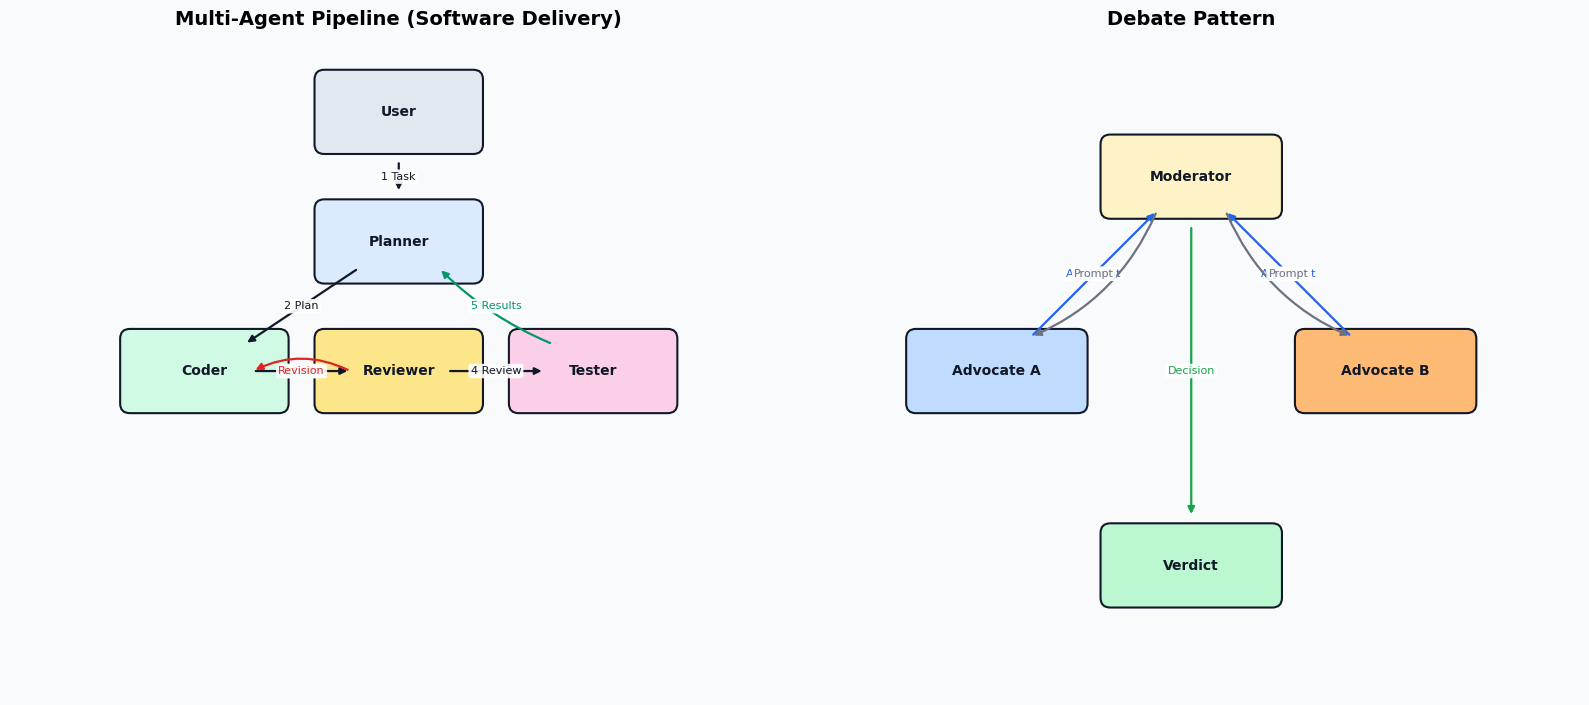

In [17]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
import numpy as np


def _edge_points(start, end, offset=0.75):
    dx = end[0] - start[0]
    dy = end[1] - start[1]
    dist = max(np.hypot(dx, dy), 1e-6)
    start_pt = (start[0] + dx / dist * offset, start[1] + dy / dist * offset)
    end_pt = (end[0] - dx / dist * offset, end[1] - dy / dist * offset)
    return start_pt, end_pt


def _draw_node(ax, center, label, color, width=2.2, height=0.9):
    x, y = center
    rect = FancyBboxPatch(
        (x - width / 2, y - height / 2),
        width,
        height,
        boxstyle="round,pad=0.2,rounding_size=0.15",
        facecolor=color,
        edgecolor="#111827",
        linewidth=1.5,
    )
    ax.add_patch(rect)
    ax.text(
        x,
        y,
        label,
        ha="center",
        va="center",
        fontsize=10,
        fontweight="bold",
        color="#111827",
    )


def _draw_arrow(ax, start, end, color="#111827", label=None, rad=0.0, lw=1.6):
    s, e = _edge_points(start, end)
    ax.annotate(
        "",
        xy=e,
        xytext=s,
        arrowprops=dict(
            arrowstyle="-|>",
            color=color,
            lw=lw,
            connectionstyle=f"arc3,rad={rad}",
        ),
    )
    if label:
        mx, my = (s[0] + e[0]) / 2, (s[1] + e[1]) / 2
        ax.text(
            mx,
            my,
            label,
            fontsize=8,
            color=color,
            ha="center",
            va="center",
            bbox=dict(boxstyle="round,pad=0.2", fc="#FFFFFF", ec="none", alpha=0.9),
        )


def visualize_multi_agent_system():
    plt.rcParams["font.family"] = "DejaVu Sans"

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    fig.patch.set_facecolor("#F8FAFC")

    # === Left: Pipeline ===
    ax1 = axes[0]
    ax1.set_xlim(0, 12)
    ax1.set_ylim(0, 10)
    ax1.set_aspect("equal")
    ax1.axis("off")
    ax1.set_title("Multi-Agent Pipeline (Software Delivery)", fontsize=14, fontweight="bold", pad=16)
    ax1.set_facecolor("#F1F5F9")

    positions = {
        "User": (6, 9),
        "Planner": (6, 7),
        "Coder": (3, 5),
        "Reviewer": (6, 5),
        "Tester": (9, 5),
    }

    colors = {
        "User": "#E2E8F0",
        "Planner": "#DBEAFE",
        "Coder": "#D1FAE5",
        "Reviewer": "#FDE68A",
        "Tester": "#FBCFE8",
    }

    for name, pos in positions.items():
        _draw_node(ax1, pos, name, colors[name])

    main_flow = [
        ("User", "Planner", "1 Task"),
        ("Planner", "Coder", "2 Plan"),
        ("Coder", "Reviewer", "3 Code"),
        ("Reviewer", "Tester", "4 Review"),
    ]

    for src, dst, label in main_flow:
        _draw_arrow(ax1, positions[src], positions[dst], color="#111827", label=label)

    _draw_arrow(
        ax1,
        positions["Tester"],
        positions["Planner"],
        color="#059669",
        label="5 Results",
        rad=-0.1,
    )

    _draw_arrow(
        ax1,
        positions["Reviewer"],
        positions["Coder"],
        color="#DC2626",
        label="Revision",
        rad=0.25,
    )

    # === Right: Debate ===
    ax2 = axes[1]
    ax2.set_xlim(0, 12)
    ax2.set_ylim(0, 10)
    ax2.set_aspect("equal")
    ax2.axis("off")
    ax2.set_title("Debate Pattern", fontsize=14, fontweight="bold", pad=16)
    ax2.set_facecolor("#F1F5F9")

    debate_pos = {
        "Moderator": (6, 8),
        "Advocate A": (3, 5),
        "Advocate B": (9, 5),
        "Verdict": (6, 2),
    }

    debate_colors = {
        "Moderator": "#FEF3C7",
        "Advocate A": "#BFDBFE",
        "Advocate B": "#FDBA74",
        "Verdict": "#BBF7D0",
    }

    for name, pos in debate_pos.items():
        _draw_node(ax2, pos, name, debate_colors[name], width=2.4)

    _draw_arrow(ax2, debate_pos["Advocate A"], debate_pos["Moderator"], color="#2563EB", label="Argument")
    _draw_arrow(ax2, debate_pos["Advocate B"], debate_pos["Moderator"], color="#2563EB", label="Argument")
    _draw_arrow(ax2, debate_pos["Moderator"], debate_pos["Advocate A"], color="#6B7280", label="Prompt", rad=-0.2)
    _draw_arrow(ax2, debate_pos["Moderator"], debate_pos["Advocate B"], color="#6B7280", label="Prompt", rad=0.2)
    _draw_arrow(ax2, debate_pos["Moderator"], debate_pos["Verdict"], color="#16A34A", label="Decision")

    plt.tight_layout()
    plt.show()


visualize_multi_agent_system()

## 总结

### 我们构建了什么

1. **真实的 LLM 驱动智能体**：每个智能体使用真实的 LLM 推理，而非模式匹配
2. **软件开发流水线**：Planner -> Coder -> Reviewer -> Tester，并带反馈回路
3. **辩论系统**：多视角观点争论，主持人客观评估

### 关键模式

| 模式 | 适用场景 | 智能体 |
|---------|----------|--------|
| **流水线** | 顺序处理 | Planner -> Coder -> Reviewer -> Tester |
| **监督者** | 协同调度 | Planner 协调所有智能体 |
| **辩论** | 多视角分析 | 辩手 + 主持人 |
| **反馈回路** | 质量提升 | Reviewer -> Coder 修订 |

### 生产环境注意事项

- **持久化**：将智能体状态与消息存入数据库
- **异步处理**：使用队列进行可扩展的消息传递
- **错误处理**：智能体失败时优雅降级
- **监控**：记录所有智能体交互用于调试
- **成本控制**：为每个智能体设置 token 预算

### 适用场景

- **软件开发**：自动化代码生成与审查
- **内容生产**：Research -> Write -> Edit 流水线
- **决策支持**：多视角分析
- **客户服务**：Triage -> Specialist -> Resolution
